# Итоговый проект
#### Гордеев Никита

Мой проект представляет собой два небольших самостоятельных исследования, посвящённых современной музыке.

In [10]:
import spotipy
import re
import lyricsgenius as genius
import requests
import os
import shutil
import unicodedata
import billboard
import pandas as pd
import matplotlib.pyplot as plt
import conf
import rpy2.robjects as ro
import warnings

from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import util
from IPython.display import Image, HTML, display
from lyricsgenius.utils import sanitize_filename
from bs4 import BeautifulSoup

In [ ]:
warnings.filterwarnings('ignore')

## Часть 1. Как менялось звучание суперхитов последние 20 лет?

Чтобы как-то ответить на этот вопрос нужно было определиться с двумя вещами:

- Что мы будем считать "суперхитами"? 
- Как мы будем анализировать музыкальную составляющую песен?

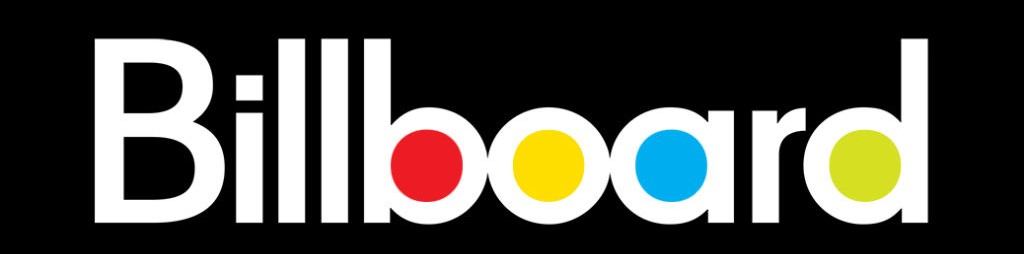

Ответ на первый вопрос: "суперхитами" обозначим песни, попадавшие топ-10 главного синглового чарта крупнейшего музыкального рынка мира - Billboard Hot-100.

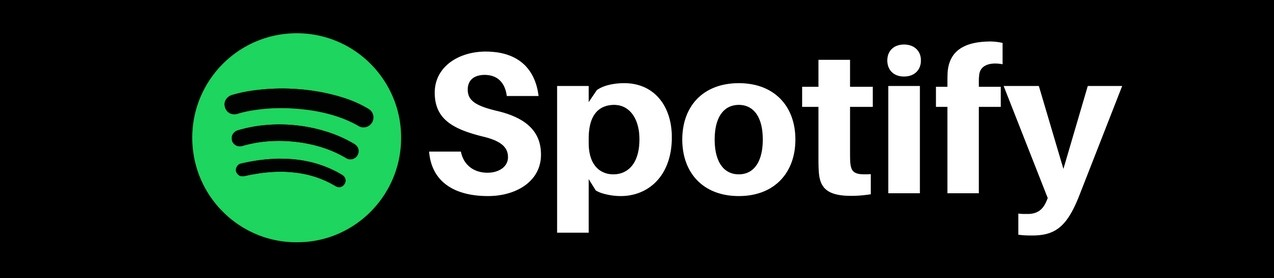

Ответить на второй вопрос нам поможет Spotify, имеющий в арсенале мощный инструмент анализа аудидорожек на основе свёрточных нейронных сетей. С помощью него стриминговый гигант продвигает потенциальные хиты малоизвестных музыкантов. Анализ позволяет выделить достаточно много характеристик, но мы ограничимся 5-ю:

- danceability - то, насколько песня пригодна для танца (темп, постоянство ритма, "кач");
- tempo - стандартная величина bpm;
- energy - интенсивность, активность композиции, субъективно ощущающаяся как скорость, зашумлённость и громкость;
- speechiness - то, насколько текстовая составляющая трека похожа на обычный разговор: песни с мелодичным вокалом будут иметь более низкие значения, со спокойным речитативом - более высокие;
- duration - длина трека в миллисекундах.

Ниже можно послушать примеры треков с низкими и высокими значениями показателей danceability, energy и speechiness (Github не поддерживает html-виджеты, поэтому можно пройти по ссылке в README):

In [99]:
# Danceability:
# FKA twigs - thousand eyes = 0.239
# Justin Timberlake, Timbaland - SexyBack = 0.967

# Energy:
# Lana Del Rey - hope is a dangerous thing... = 0.102
# The 1975 - People = 0.932

# Speechiness:
# The Weeknd - In your Eyes = 0.0346
# Mac Miller - Blue World = 0.419

Приступаем к работе. Настраиваем токен:

In [11]:
cid = conf.S_TOKEN
secret = conf.S_SECRET
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Это функция "добычи хитов". Мы берём песни, попадавшие в топ-10 чарта Billboard Hot-100 в течение 20 лет. Так как хотелось захватить последние хит-синглы, наш учётный год не совпадает с календарным: с июня по июнь.

На выходе получаем словарь, где каждому году соответствует список топ-10 хитов главного синглового чарта США. Песни, пик популярности которых приходился на весну-лето, могут повторяться в значениях разных ключей.

In [149]:
def get_hits():

    years = [2020]
    year = 2020

    for y in range(20):
        year -= 1
        years.append(str(year))

    tby = {} #tracks by years
    chart = billboard.ChartData('hot-100')
    for year in years:
        w = 0
        tracks = []
        while chart.previousDate and w <= 51:
            try:
                chart = billboard.ChartData('hot-100', chart.previousDate)
                w += 1
                for song in chart[0:9]:
                    track = song.title.replace("'", "") + ' ' + song.artist.replace('Featuring', '')
                    if track not in tracks:
                        tracks.append(track)
            except (TypeError, RuntimeError, ConnectionError) as ex:
                pass
        tby.update({year: tracks})
        
    return tby, years

Функция get_features усредняет значения всех топ-10 синглов за один год.

In [9]:
def get_features(audio_feat):
    
    danceability = 0
    tempo = 0
    energy = 0
    speechiness = 0
    duration = 0

    for i in audio_feat:
        l = len(audio_feat)
        danceability += i[0]['danceability']
        tempo += i[0]['tempo']
        energy += i[0]['energy']
        speechiness += i[0]['speechiness']
        duration += i[0]['duration_ms']

    danceability = round(danceability / l, 3)
    tempo = round(tempo / l, 0)
    energy = round(energy / l, 3)
    speechiness = round(speechiness / l, 3)
    duration = round(duration / l, 0)
    
    return danceability, tempo, energy, speechiness, duration

Функция, присваивающая каждому треку значения его музыкальных характеристик, усредняющая их при помощи функции ниже и выдающая словарь с характеристиками "прототипического хита" каждого года:

In [10]:
def music_analyze(tby, years):
    
    fby = {} #features by years
    audio_feat = []
    for year in years:
        for t in tby[year]:
            try:
                track = sp.search(q='track:' + t, type='track')
                try:
                    track_id = track['tracks']['items'][0]['id']
                    af = sp.audio_features(track_id)
                    audio_feat.append(af)
                except IndexError:
                    pass
            except (TypeError, RuntimeError, ConnectionError) as ex:
                pass
        danceability, tempo, energy, speechiness, duration = get_features(audio_feat)
        fby.update({str(year): [danceability, tempo, energy, speechiness, duration]})
        
    return fby

In [ ]:
tby, years = get_hits()
fby = music_analyze(tby, years)

Здесь мы сортируем словарь по годам и делаем датафрейм

In [144]:
def make_df(fby):
    
    fb = {}
    list_keys = list(fby.keys())
    list_keys.sort()
    for i in list_keys:
        fb.update({i: fby[i]})
    fby = fb

    df = pd.DataFrame(fby)
    df = df.transpose()
    df = df.reset_index()
    df.columns = ['year', 'danceability','tempo', 'energy', 'speechiness', 'duration']
    
    return df

Вот такие у нас вышли результаты:

In [145]:
df = make_df(fby)
df

,year,danceability,tempo,energy,speechiness,duration
0,2000,0.609,119.0,0.742,0.099,260102.0
1,2001,0.614,125.0,0.771,0.079,250786.0
2,2002,0.620,128.0,0.745,0.087,273210.0
3,2003,0.645,126.0,0.768,0.081,248203.0
4,2004,0.641,116.0,0.726,0.080,245691.0
5,2005,0.632,122.0,0.690,0.078,247999.0
6,2006,0.643,118.0,0.718,0.076,243908.0
7,2007,0.639,123.0,0.750,0.088,252715.0
8,2008,0.657,122.0,0.692,0.104,239706.0
9,2009,0.650,129.0,0.706,0.096,237963.0


При помощи данной функции построим 5 датафреймов для каждого параметра:

In [ ]:
def make_dfs(df):
    
    val_danceability = df[['year','danceability']]
    val_danceability['year'] = val_danceability['year'].astype(str)

    val_tempo = df[['year','tempo']]
    val_tempo['year'] = val_tempo['year'].astype(str)

    val_energy = df[['year','energy']]
    val_energy['year'] = val_energy['year'].astype(str)

    val_speechiness = df[['year','speechiness']]
    val_speechiness['year'] = val_speechiness['year'].astype(str)

    val_duration = df[['year','duration']]
    val_duration['year'] = val_duration['year'].astype(str)
    
    return val_danceability, val_tempo, val_energy, val_speechiness, val_duration

val_danceability, val_tempo, val_energy, val_speechiness, val_duration = make_dfs(df)

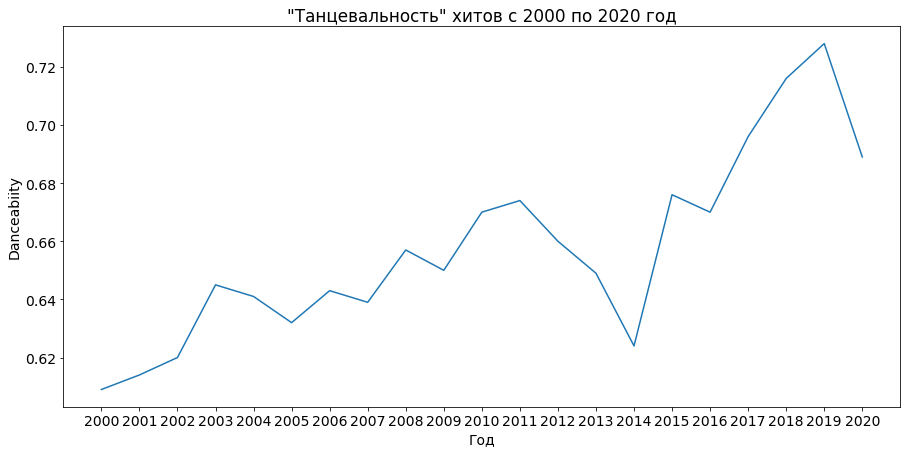

In [138]:
plt.plot(val_danceability['year'], val_danceability['danceability'])
plt.title('"Танцевальность" хитов с 2000 по 2020 год') # заголовок
plt.ylabel('Danceabiity') # подпись оси Х
plt.xlabel('Год')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams.update({'font.size': 14})

На первом графике видно, что "танцевальность" хитов за последние 20 лет возросла. Кажется, продюсеры стали ориентироваться на наличие ритмичного качающего "хука" и делать треки более единообразными. Может быть, стало меньше баллад и выстрелов нестандартных чарттоперов.

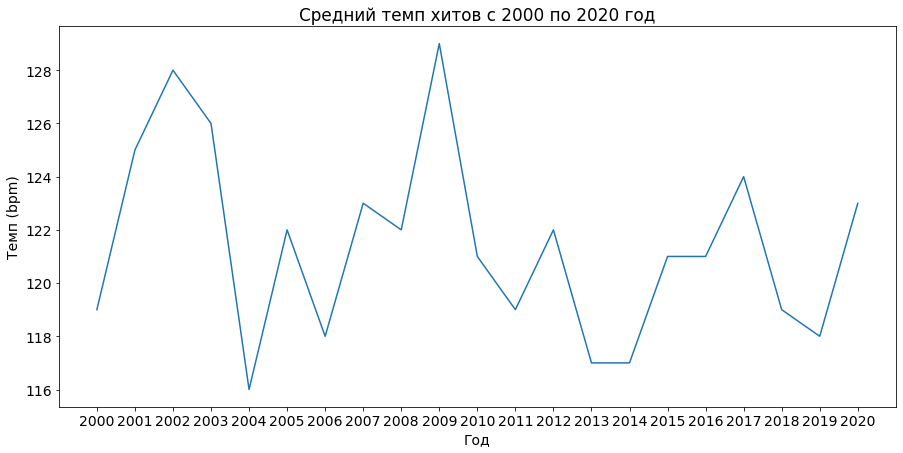

In [139]:
plt.plot(val_tempo['year'], val_tempo['tempo'])
plt.title('Средний темп хитов с 2000 по 2020 год') # заголовок
plt.ylabel('Темп (bpm)') # подпись оси Х
plt.xlabel('Год')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams.update({'font.size': 14})

Отсутствие результата - тоже результат.

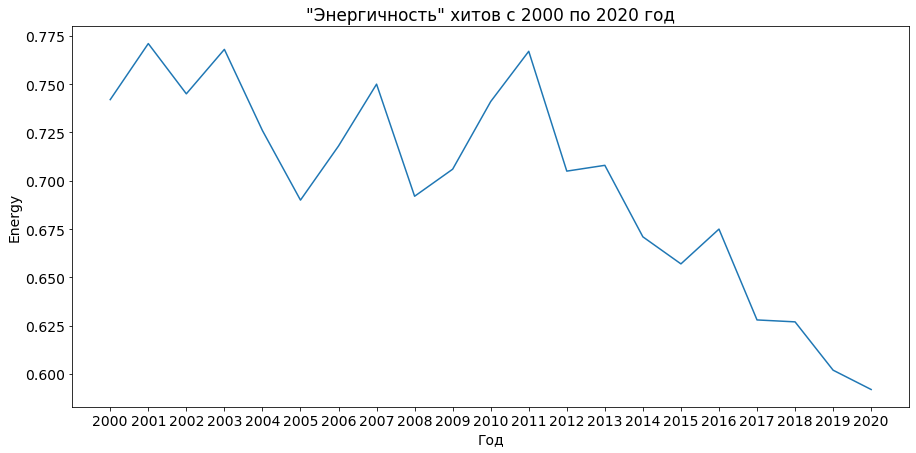

In [140]:
plt.plot(val_energy['year'], val_energy['energy'])
plt.title('"Энергичность" хитов с 2000 по 2020 год') # заголовок
plt.ylabel('Energy') # подпись оси Х
plt.xlabel('Год')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams.update({'font.size': 14})

На графике отчётливо видно, как "энергичность" песен-хитов упала за два десятилетия. Возможно, это связано со снижением популярности рок-музыки и воцарением хип-хопа новой школы. А на значения совсем последних лет могла повлиять Билли Айлиш...

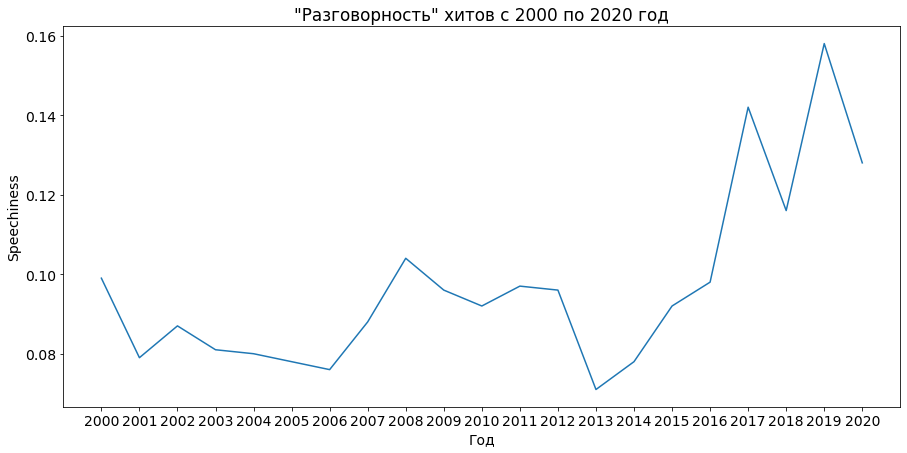

In [141]:
plt.plot(val_speechiness['year'], val_speechiness['speechiness'])
plt.title('"Разговорность" хитов с 2000 по 2020 год') # заголовок
plt.ylabel('Speechiness') # подпись оси Х
plt.xlabel('Год')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams.update({'font.size': 14})

"Разговорность" - категория, изменения в которой даже на малые диапазоны говорят о некоторых тенденциях. Скорее всего, график демонстрирует снижение авторитета сильного вокала и замещение его более расслабленным и томным пением, а так же вытеснение агрессивного хип-хопа старой школы более вольяжным клауд-рэпом.

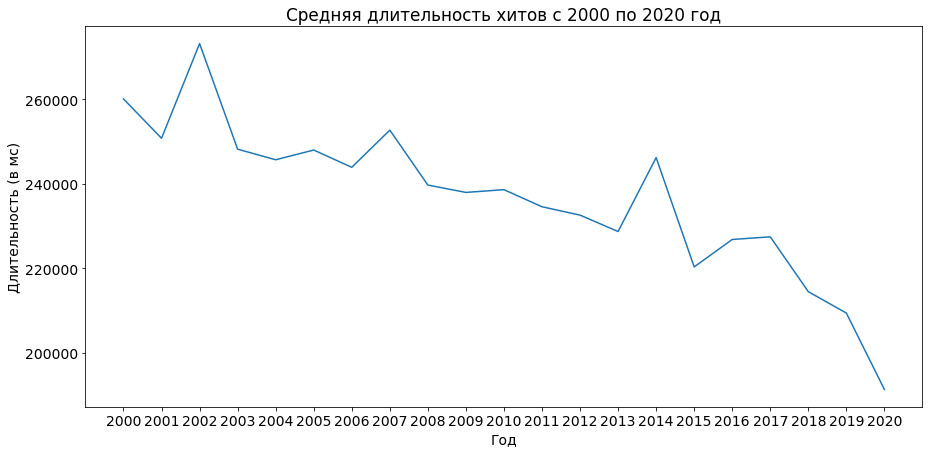

In [147]:
plt.plot(val_duration['year'], val_duration['duration'])
plt.title('Средняя длительность хитов с 2000 по 2020 год') # заголовок
plt.ylabel('Длительность (в мс)') # подпись оси Х
plt.xlabel('Год')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams.update({'font.size': 14})

Самым репрезентативным кажется последний график: отчётливо видна тенденция к уменьшению длительности песен. Объяснение данному феномену можно найти следующее: в эру стриминга артисты получают прибыль от прослушиваний песен на музыкальных сервисах; а чем короче треки, тем чаще они прокручиваются в плейлистах и тем чаще слушатели осиливают целые альбомы. Ещё одна возможная причина - снижение слушательской культуры благодаря приложениям типа TikTok, предлагающим пользователям короткие отрывки песен в качества фона в развлекательных видео. Люди привыкают слушать лишь самый "хитовый" момент и ленятся слушать длинные композиции.

Вот такие результаты: хиты стали короче, танцевальнее, наполненнее речетативом и спокойнее.

## Часть 2. Обкачка текстов дискографий и подготовка материалов для стилометрии.

Эта часть кода обкачивает тексты студийных альбомов с сайта Genius и формирует из них корпус в необходимом для стилометрии виде.

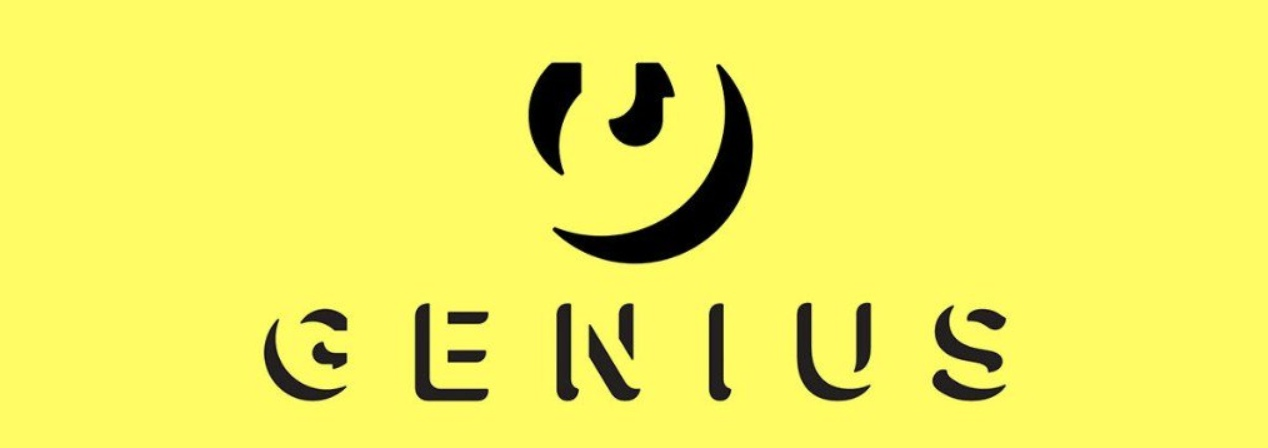

В нашей выборке уже есть 80 исполнителей: добавим ещё 10. 
В данной функции мы получаем список студийных альбомов артистов.

In [ ]:
artists = ['The Strokes', 'My Bloody Valentine', 'Soundgarden', 'Dua Lipa',
          'Post Malone', 'Camila Cabello', 'One Direction', 'Avril Lavigne',
          'Vampire Weekend', 'Godsmack']

def prepare(artists):
    strings = []
    for artist in artists:
        albums = []
        albums.append(artist.lower())
        artist = sp.search(q='artist:' + artist, type='artist')
        artist = artist['artists']['items'][0]['id']
        alb = sp.artist_albums(artist)
        for i in range(len(alb['items'])):
            a = alb['items'][i]['name'].lower()
            if alb['items'][i]['album_group'] == 'album' and a not in albums[1:]:
                if re.search('(?: edition|deluxe|anniversary)', a) is None: #удаляем дополнительные издания
                    albums.append(a)
        strings.append(albums)
    return strings

Эта функция преобразует имена артистов и названия альбомов в формат, пригодный для составления ссылок на страницы лонгплеев на Genius:

In [ ]:
def link_for_genius(name):
    name = re.sub('[^A-Za-z0-9]+', '-', name)
    if name.endswith('-'):
        name = name[:-1]
    if name.startswith('-'):
        name = name[1:]
        
    return name

Данная функция создаёт текстовый файл с именами артистов и списком их альбомов, который краулер возьмёт на вход.

In [ ]:
def lp_list(strings):

    for i in range(len(strings)):
        for j in range(len(strings[i])):
            strings[i][j] = link_for_genius(strings[i][j])
    st = []
    for i in strings:
        s = ' '.join(i)
        st.append(s)
    st = '\n'.join(st)
    
    with open('artists and albums.txt', 'w', encoding='utf-8') as f:
        f.write(st)

Настраиваем API, указываем в настройках невалидные варианты треков (переводы, живые исполнени, ремиксы) и читаем получившийся файл.

In [153]:
def make_api():
    
    g_token = conf.G_TOKEN
    api = genius.Genius(g_token)
    genius.remove_section_headers = True
    genius.excluded_terms = ["(Remix)", "(Live)", "Remix", "mix", "Edition", 
                             '(Traducción al Español)', '(Tradução em Português)', 
                             '(Deutsche Übersetzung)', '(Turkish Translation)', 
                             '(Traduction Française)', '(Türkçe Çeviri)', 
                             '(Traduzione Italiana)', '(Český Překlad)', 
                             '(Dansk Oversættelse)', '(Traducerea Românească)',
                             '([0-9a-zA-Z -]* Remix)', '(Demo)']
    genius.skip_non_songs = True
    with open('artists and albums.txt', encoding='utf-8') as f:
        text = f.read()
    li = re.findall('([a-zA-Z0-9\- ]*)\n', text)
    return (api, li)

Так как учесть все случаи несовпадения нашей гипотетической ссылки на альбом и реальной невозможно: всегда остаются неучтённые нюансы, сделаем функцию проверки наших ссылок. Если пройдя по адресу, программа выйдет на страницу с ошибкой, мы увидим, что он нерабочий, и сможем проверить и поправить его вручную.

In [ ]:
def check_links(li):
    for artist in li:
        artist = artist.split()
        for album in range(1, len(artist)):
            album = artist[album]
            link = 'https://genius.com/albums/' + artist[0] + '/' + album
            result = requests.get(link)
            html = result.text
            if re.search('Oops', html):
                print(album, '!!!!!!!!!!!!!!!!NOT OK!!!!!!!!!!!!!!!!')
            else:
                print(album,'OK')

Сердце нашей машины: здесь программа заполучает трек-листы всех студийных альбомов всех музыкантов, ищет каждую отдельно взятую песню и сохраняет её текст в отдельный файл с соответстующим именем.

In [ ]:
def prepare_database(api, li):
    
    os.makedirs("Database", exist_ok=True)
    for artist in li:
        os.makedirs('corpus', exist_ok=True)
        artist = artist.split()
        name_dir = artist[0]
        os.makedirs(name_dir, exist_ok=True)
        for album in range(1, len(artist)):
            album = artist[album]
            link = 'https://genius.com/albums/' + artist[0] + '/' + album
            result = requests.get(link)
            html = result.text
            soup = BeautifulSoup(html,'html.parser')
            for song in soup.find_all('h3', {'class': 'chart_row-content-title'}):
                song_name = song.get_text()
                song_name = unicodedata.normalize("NFKD", song_name)
                song_name = re.search('( +)(.+)(\n)', song_name).group(2)
                try:
                    song = api.search_song(song_name, artist[0])
                    song_name = sanitize_filename(song_name).replace('-', '')
                    album = album.replace('-', '')
                    name = album + '_' + song_name
                    for i in terms:
                        if re.search(i, str(song)):
                            song = None
                    if song is not None: 
                        song.save_lyrics(extension='txt', filename= name, overwrite= True, binary_encoding=True)
                        name = name + '.txt'
                        shutil.move(name, 'corpus')
                except (TypeError, RuntimeError) as ex:
                    pass
        shutil.move('corpus', name_dir)
        shutil.move(name_dir, 'Database')

In [ ]:
api, li = make_api()
prepare_database(api, li)

Можно анализировать кластеризацию текстов по альбомам в рамках дискографии одного артиста, можно применять алгоритмы стилометрии к альбомам, а можно к самим артистам, и это будут три разных исследования. Чтобы мы могли провести любое из них, добавим ещё две функции. Одна будет объединять файлы с текстами песен в файлы с текстами альбомов: 

In [37]:
def integrate_songs():
    
    os.makedirs('./Database/Albums/corpus', exist_ok=True)
    folder_list = os.listdir('./Database')
    folder_list.remove('Albums')
    if 'Artists' in folder_list:
        folder_list.remove('Artists')
    for folder in folder_list:
        albs = []
        direct = './Database/' + folder + '/corpus/'
        file_list = os.listdir(direct)
        for file in file_list:
            album_name = re.search('([a-z0-9-]*)(_)', file).group(1)
            if album_name not in albs:
                albs.append(album_name)
        for album_name in albs:
            nname = direct + folder + '_' + album_name + '.txt'
            texts = ''
            for file in file_list:
                filenname = direct + file
                if file.startswith(album_name):
                    with open(filenname, encoding='utf-8') as f:
                        text = f.read()
                        texts = texts + text
            check_path = './Database/Albums/corpus/' + folder + '_' + album_name + '.txt'
            if os.path.exists(check_path):
                pass
            else:
                with open(nname, 'w', encoding='utf-8') as f:
                    f.write(texts)
                shutil.move(nname, './Database/Albums/corpus')

А другая составлять из файлов с текстами альбомов файлы с полной лирикографией артистов:

In [38]:
def integrate_lps():
    
    os.makedirs('./Database/Artists/corpus', exist_ok=True)
    arts = []
    file_list = os.listdir('./Database/Albums/corpus')
    for file in file_list:
        artist_name = re.search('([A-Za-z0-9-]*)(_)', file).group(1)
        if artist_name not in arts:
            arts.append(artist_name)
    for artist_name in arts:
        nname = './Database/Albums/corpus/' + artist_name + '.txt'
        texts = ''
        for file in file_list:
            filenname = './Database/Albums/corpus/' + file
            if file.startswith(artist_name):
                with open(filenname, encoding='utf-8') as f:
                    text = f.read()
                    texts = texts + text
        check_path = './Database/Artists/corpus/' + artist_name + '.txt'
        if os.path.exists(check_path):
            pass
        else:
            with open(nname, 'w', encoding='utf-8') as f:
                f.write(texts)
            shutil.move(nname, './Database/Artists/corpus')

In [200]:
integrate_songs()
integrate_lps()

Работаем с пакетом stylo для языка R:

In [202]:
R = ro.r
R.library('stylo')

R[write to console]: 
### stylo version: 0.7.1 ###

If you plan to cite this software (please do!), use the following reference:
    Eder, M., Rybicki, J. and Kestemont, M. (2016). Stylometry with R:
    a package for computational text analysis. R Journal 8(1): 107-121.
    <https://journal.r-project.org/archive/2016/RJ-2016-007/index.html>

To get full BibTeX entry, type: citation("stylo")



'stylo','tools','stats',...,'datasets','methods','base'


In [ ]:
R.setwd('./Database/Artists')
R.stylo()

Вот так выглядит дерево лирической близости:

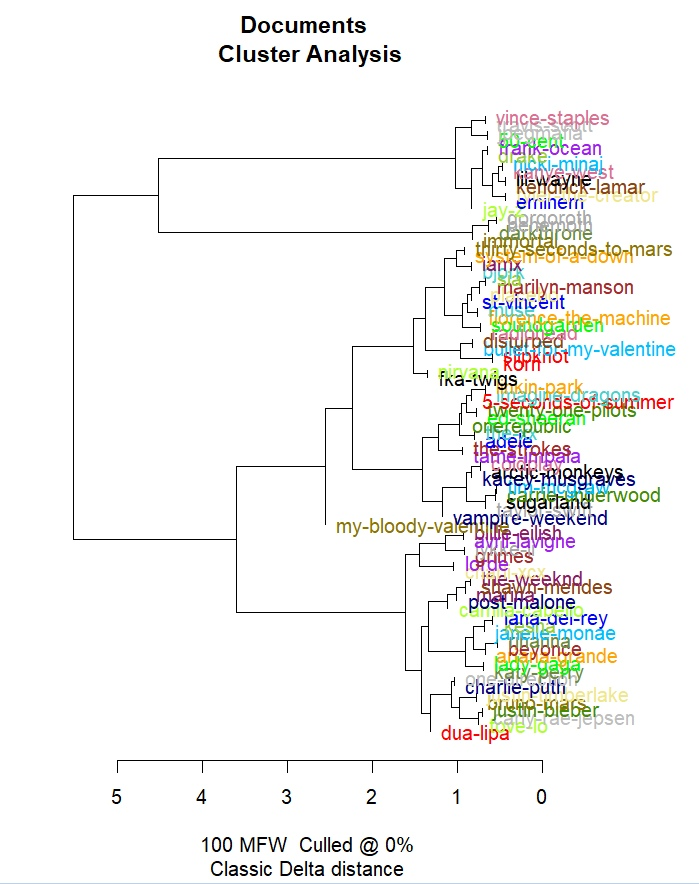

Для более красивой и наглядной визуализации обратимся к сторонней программе для построения сетей - Gephi:

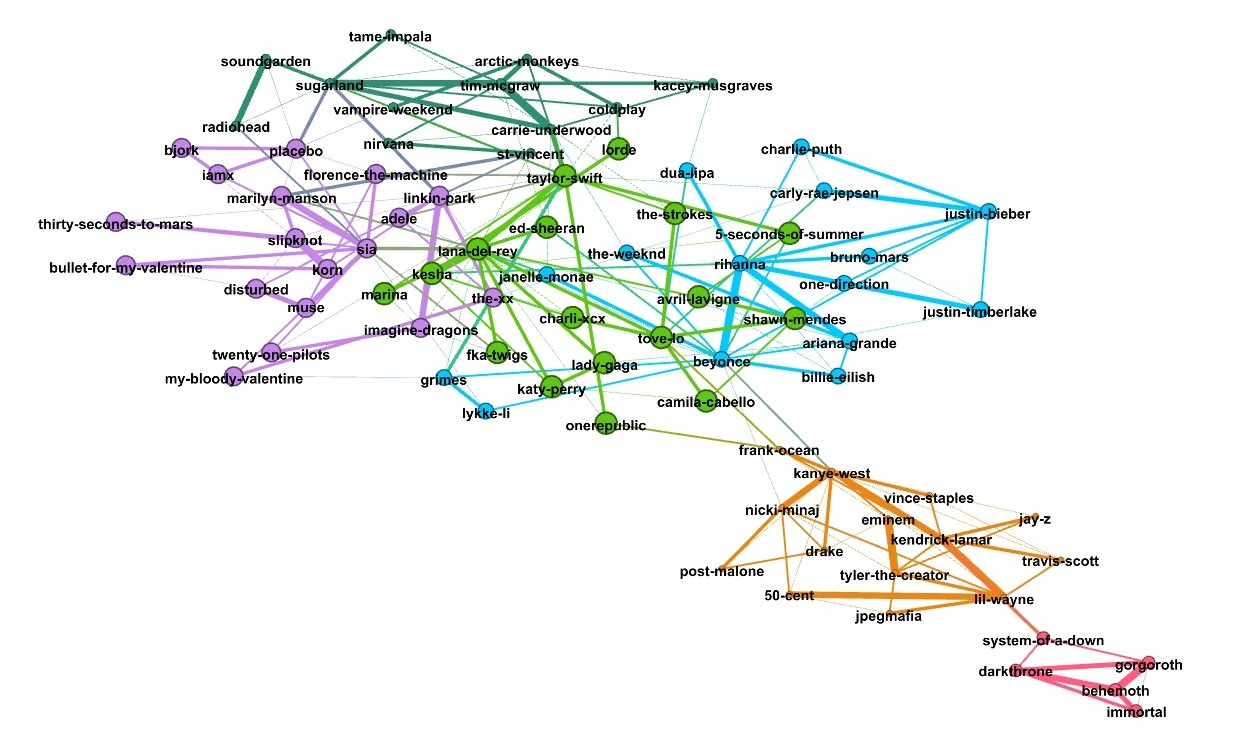

Что мы видим? Довольно хорошую кластеризацию исполнителей по жанрам:
- блэк-металисты и System of a Down в нижнем правом углу;
- вся-вся хип-хоп-тусовка чуть выше в оранжевом кластере;
- альтернативные рок-группы в сиреневом кластере;
- промежуточное положение между ними и поп-исполнителями занимают певицы жанра инди-поп и завсегдатаи чартов Adult Pop;
- сине-зелёный поп-кластер с расхождениями классической баблгам-поп музыки влево и R&b вправо.

## Планы.

- продолжить собирание корпуса песенной лирики;
- сделать токенизацию текстов для разного рода исследований: например, анализ различий лексического наполнения популярных концептов в разных жанрах с помощью word2vec;
- попробовать заменить готовые методы анализа аудио Spotify обработкой с помощью пакета librosa, "пощупать" звук и, возможно, найти более удачные варианты вычленения музыкальных компонент;
- искать интересные корреляции музыкальных характеристик и текстовых особенностей;
- воспроизвести подобные первой части проекта исследования, сосредоточившись на определённых жанрах и странах.

# Спасибо за внимание!